### Welcome to the D 3.5 Repository Evaluation Notebook

This notebook serves as supplemental material to the analysisy contained in SSHOC Deliverable D 3.5. The analysis made  uses the information collected in the document [D 3.5 Repository Evaluation](https://docs.google.com/spreadsheets/d/1h3ZKLv_aR3sqjpKQ67uyzzsJXLWV7Yo-clX4BzVxJGE/edit#gid=1723227300) to create a db of information about repositories,  for a number of such repositories the data is enriched with the information provided by [Re3Data](https://www.re3data.org/). 

### Install and download data

In [1]:
import pandas as pd
import requests
import re
import pickle
import os.path
import os
import json
import numpy as np
import xml.etree.ElementTree as ET

In [2]:
def getRe3data(repid):
    headers_dict = {"locale":"en-EN"};
    labels=['re3data.orgIdentifier','institutionName', 'repositoryName',
       'repositoryURL', 'contentType','type','keyword',
       'additionalName', 'enhancedPublication',
       "pidSystem", 'versioning',
       'dataLicenseURL','dataAccessType','metadataStandardName', 'api']

    cols = []
    data = []
    df_n1=pd.DataFrame(columns=labels)

    for repid in repids:
        rd =requests.get(repurl+repid, headers=headers_dict, timeout=3)
        root = ET.XML(rd.text)  # Parse XML
        data=[]
        for label in labels:
            #print (label)
            value=[]
            for elem in root.iter('{http://www.re3data.org/schema/2-2}'+label):
                #print (elem.text)
                value.append(elem.text)
            #print(value)
            data.append(value)
        a_series = pd.Series(data, index = df_n1.columns)
        df_n1=df_n1.append(a_series, ignore_index=True)

        #df_n = pd.DataFrame(data).T
    #df_n.columns =labels
    #df_n1.head(15)
    return df_n1;

In [3]:
url='https://www.re3data.org/api/v1/repositories'
df_desc_par=pd.read_xml(url)

In [4]:
#r3d100010136
df_desc_par.shape

(2749, 3)

In [5]:
repurl='https://www.re3data.org/api/v1/repository/'
repids=df_desc_par['id'].values

In [6]:
#df_n1=getRe3data(repids)
#df_n1.to_pickle('../data/re3data.pickle')

In [7]:
df_n1 = pd.read_pickle('../data/re3data.pickle')

In [8]:
df_re=pd.read_csv(filepath_or_buffer='../data/datarepo.csv')

In [9]:
df_sshoc_repo=df_re[['Community', 'Repository name', 'Abbreviation', 'Host organisation', 'Country', 'Website', 're3data_id','Discipline_subject ', 'example_id', 'PID system', 'model_citation_lp']]
#df_sshoc_repo.tail()


In [10]:
df_sshoc_repo['PID system']=df_sshoc_repo['PID system'].apply(lambda y: 'na' if y is np.nan else y)
#df_sshoc_repo['PID system'].tail()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [11]:
df_n1.metadataStandardName=df_n1.metadataStandardName.apply(lambda y: ['none'] if len(y)==0 else y)
df_n1.pidSystem=df_n1.pidSystem.apply(lambda y: np.nan if ','.join(map(str, y))=='none' else y)

In [12]:
#df_n1['MetadataStandard']=[', '.join(map(str, l)) for l in df_n1['metadataStandardName']]
df_n1['identifier']=['https://www.re3data.org/repository/'+ ''.join(map(str, l)) for l in df_n1['re3data.orgIdentifier']]#df_n1['re3data.orgIdentifier']

In [13]:
test=pd.merge(left=df_sshoc_repo, right=df_n1, left_on='re3data_id', right_on='identifier', how='left').fillna(np.nan)

In [14]:
test_ex=test.explode('metadataStandardName')

In [15]:
test_ex['metadataStandardName']=test_ex['metadataStandardName'].apply(lambda y: 'na' if y is np.nan else y)

### Number of repositories by Metadata Standards

In [16]:
df_ms_ex=test_ex['metadataStandardName'].value_counts()
df_ms_ex.head()

na                                     78
Dublin Core                            29
DDI - Data Documentation Initiative    15
none                                   11
DataCite Metadata Schema                5
Name: metadataStandardName, dtype: int64

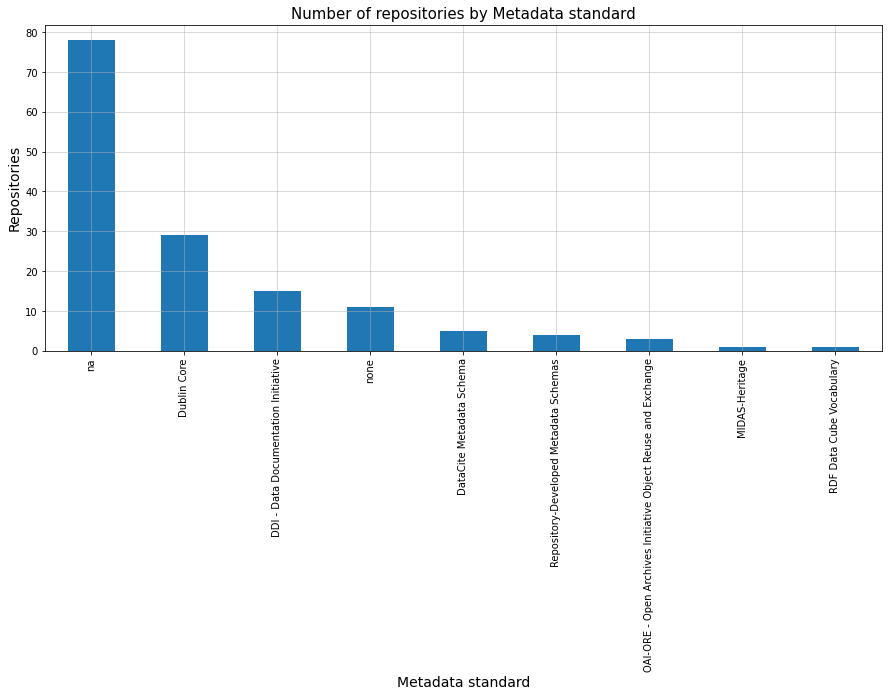

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df_ms_ex.plot(kind='bar', figsize=(15,6))
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of repositories by Metadata standard", fontsize=15)
ax.set_xlabel('Metadata standard', fontsize=14)
ax.set_ylabel('Repositories', fontsize=14);
plt.show()

### Number of repositories by PID Type

In [18]:

test["pidSystem"].fillna(test["PID system"], inplace=True)

In [19]:
test["pidSystem"]=test["pidSystem"].apply(lambda y: 'none' if (y=='None' or y=='none') else y)
test["pidSystem"]=test["pidSystem"].apply(lambda y: y if isinstance(y, list) else [y])

In [20]:
test_pis_ex=test.explode('pidSystem')

In [21]:
pippo_pis_ex=test_pis_ex['pidSystem'].value_counts()
pippo_pis_ex.head(10)

hdl                       35
na                        31
none                      28
DOI                       23
Can't find                10
URN                        4
Other (local)              1
PURL                       1
Other - permanent URLs     1
Permalink                  1
Name: pidSystem, dtype: int64

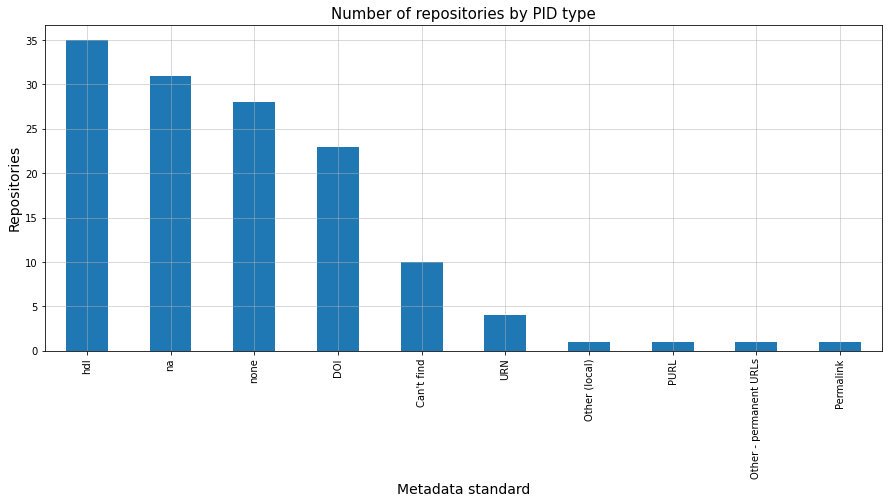

In [22]:
fig, ax = plt.subplots()
pippo_pis_ex.plot(kind='bar', figsize=(15,6))
plt.grid(alpha=0.6)
ax.yaxis.set_label_text("")
ax.set_title("Number of repositories by PID type", fontsize=15)
ax.set_xlabel('Metadata standard', fontsize=14)
ax.set_ylabel('Repositories', fontsize=14);
plt.show()

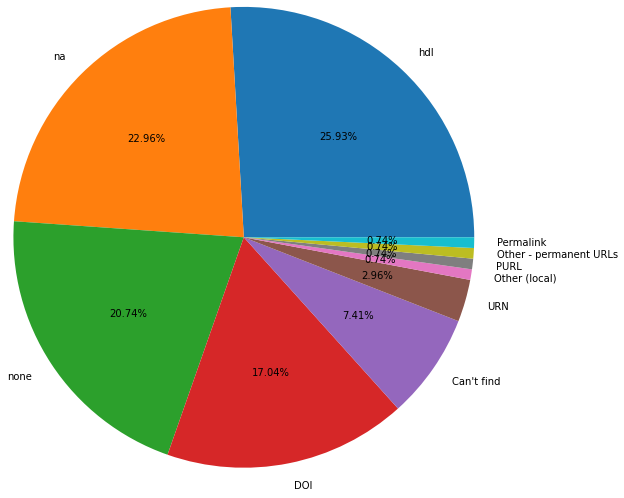

In [23]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
explode = [0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3]

ax.pie(pippo_pis_ex.values, labels = pippo_pis_ex.index,   autopct='%1.2f%%', radius = 2)
plt.show()

### Inspect PID Type

In [24]:
df_pis_kw=test_pis_ex.explode('metadataStandardName')

In [25]:
df_pis_kw['metadataStandardName']=df_pis_kw['metadataStandardName'].apply(lambda y: 'none' if y is np.nan else y)

In [26]:
tt_a_df=df_pis_kw.groupby(['metadataStandardName', 'pidSystem']).count()['Repository name'].unstack('pidSystem')
#tt_a_df.head(10)

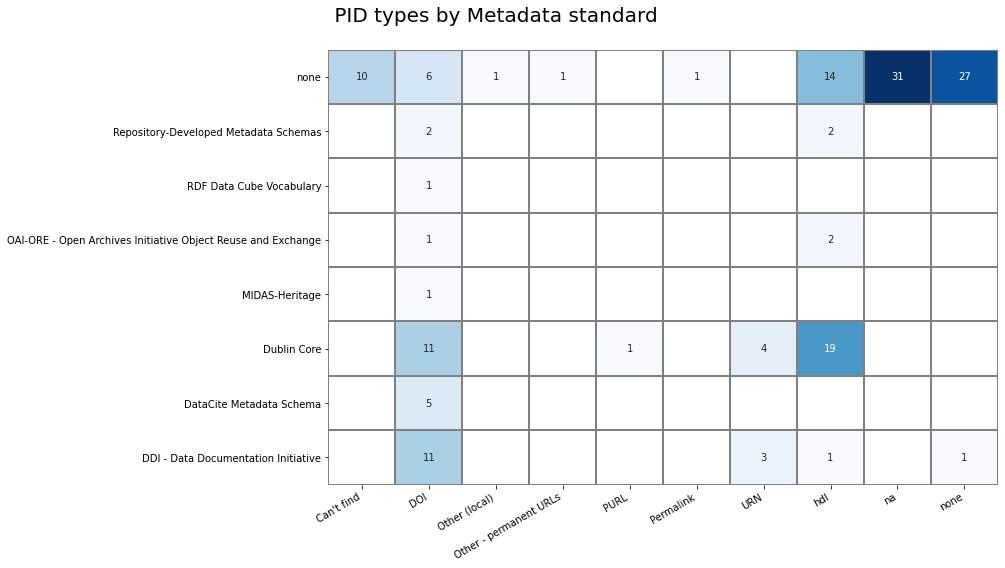

In [27]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(tt_a_df, annot=True, linewidths=0.1, fmt='.0f', ax=ax, cbar=None, cmap='Blues', linecolor='gray')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
ax.set_xlabel(None)
ax.set_ylabel(None)
#sns.heatmap(df, linewidths=2, linecolor='yellow')
title = ' PID types by Metadata standard\n'
plt.title(title, loc='left', fontsize=20)
plt.show()

In [28]:
comm_a_df=df_pis_kw.groupby(['Community', 'pidSystem']).count()['Repository name'].unstack('pidSystem')

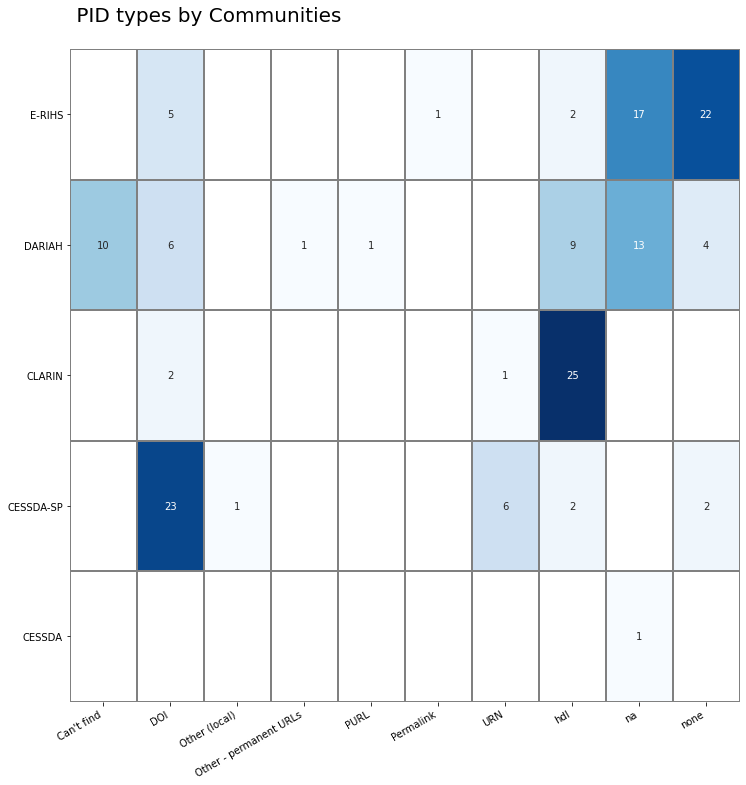

In [29]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(comm_a_df, annot=True, linewidths=0.1, fmt='.0f', ax=ax, cbar=None, cmap='Blues', linecolor='gray')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
ax.set_xlabel(None)
ax.set_ylabel(None)
#sns.heatmap(df, linewidths=2, linecolor='yellow')
title = ' PID types by Communities\n'
plt.title(title, loc='left', fontsize=20)
plt.show()

In [30]:
ds_a_df=df_pis_kw.groupby(['Discipline_subject ', 'pidSystem']).count()['Repository name'].unstack('pidSystem')


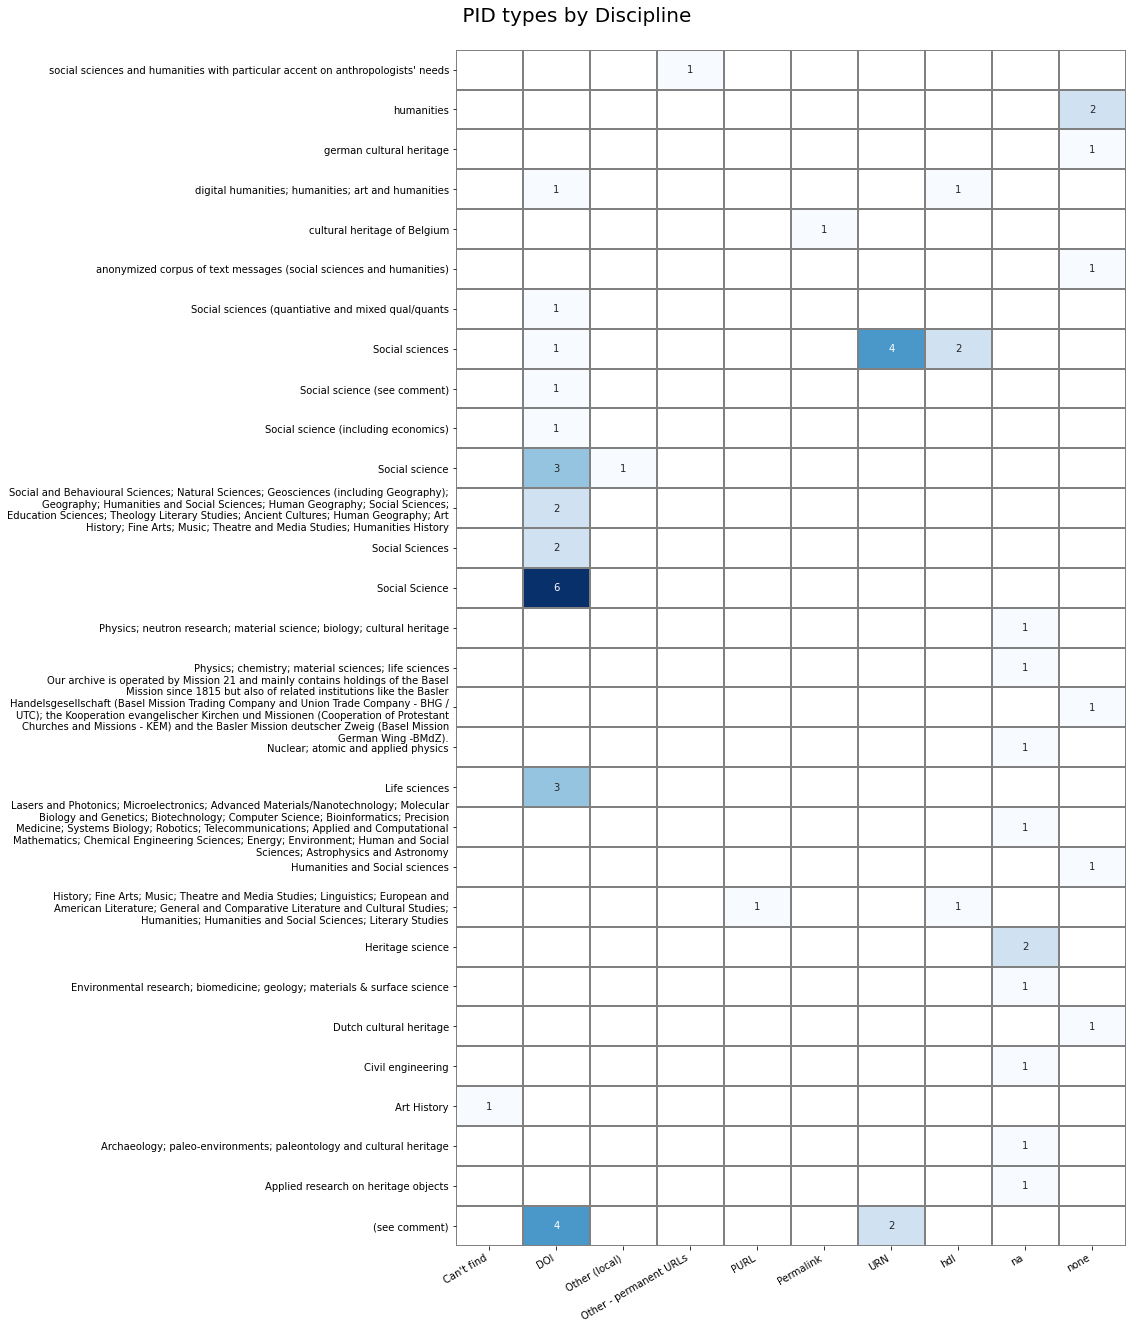

In [31]:
import textwrap
fig, ax = plt.subplots(figsize=(12, 22))
sns.heatmap(ds_a_df, annot=True, linewidths=0.1, fmt='.0f', ax=ax, cbar=None, cmap='Blues', linecolor='gray')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
#ax.set_yticklabels([textwrap.fill(e, 7) for e in data['Client Name'].head()])
ax.set_yticklabels([textwrap.fill(e, 85) for e in ds_a_df.index], rotation=0)
#ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
ax.set_xlabel(None)
ax.set_ylabel(None)
#sns.heatmap(df, linewidths=2, linecolor='yellow')
title = ' PID types by Discipline\n'
plt.title(title, loc='left', fontsize=20)
plt.show()

In [32]:
co_a_df=df_pis_kw.groupby(['Country', 'pidSystem']).count()['Repository name'].unstack('pidSystem')


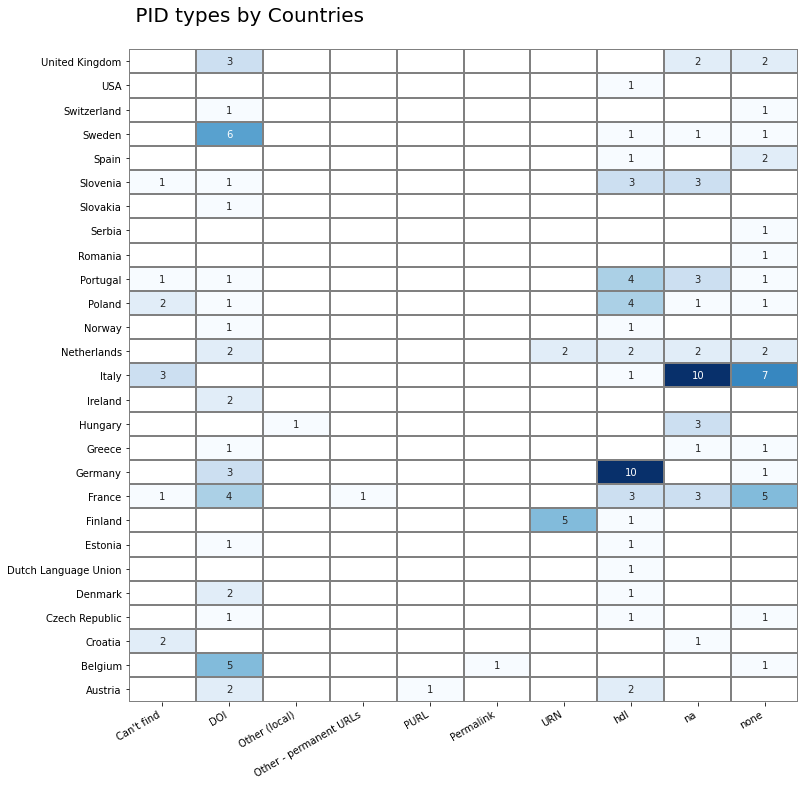

In [33]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(co_a_df, annot=True, linewidths=0.1, fmt='.0f', ax=ax, cbar=None, cmap='Blues', linecolor='gray')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.invert_yaxis()
ax.set_xlabel(None)
ax.set_ylabel(None)
#sns.heatmap(df, linewidths=2, linecolor='yellow')
title = ' PID types by Countries\n'
plt.title(title, loc='left', fontsize=20)
plt.show()

In [34]:
mc_a_df=df_pis_kw.groupby(['Discipline_subject ', 'model_citation_lp']).count()['Repository name'].unstack('model_citation_lp')

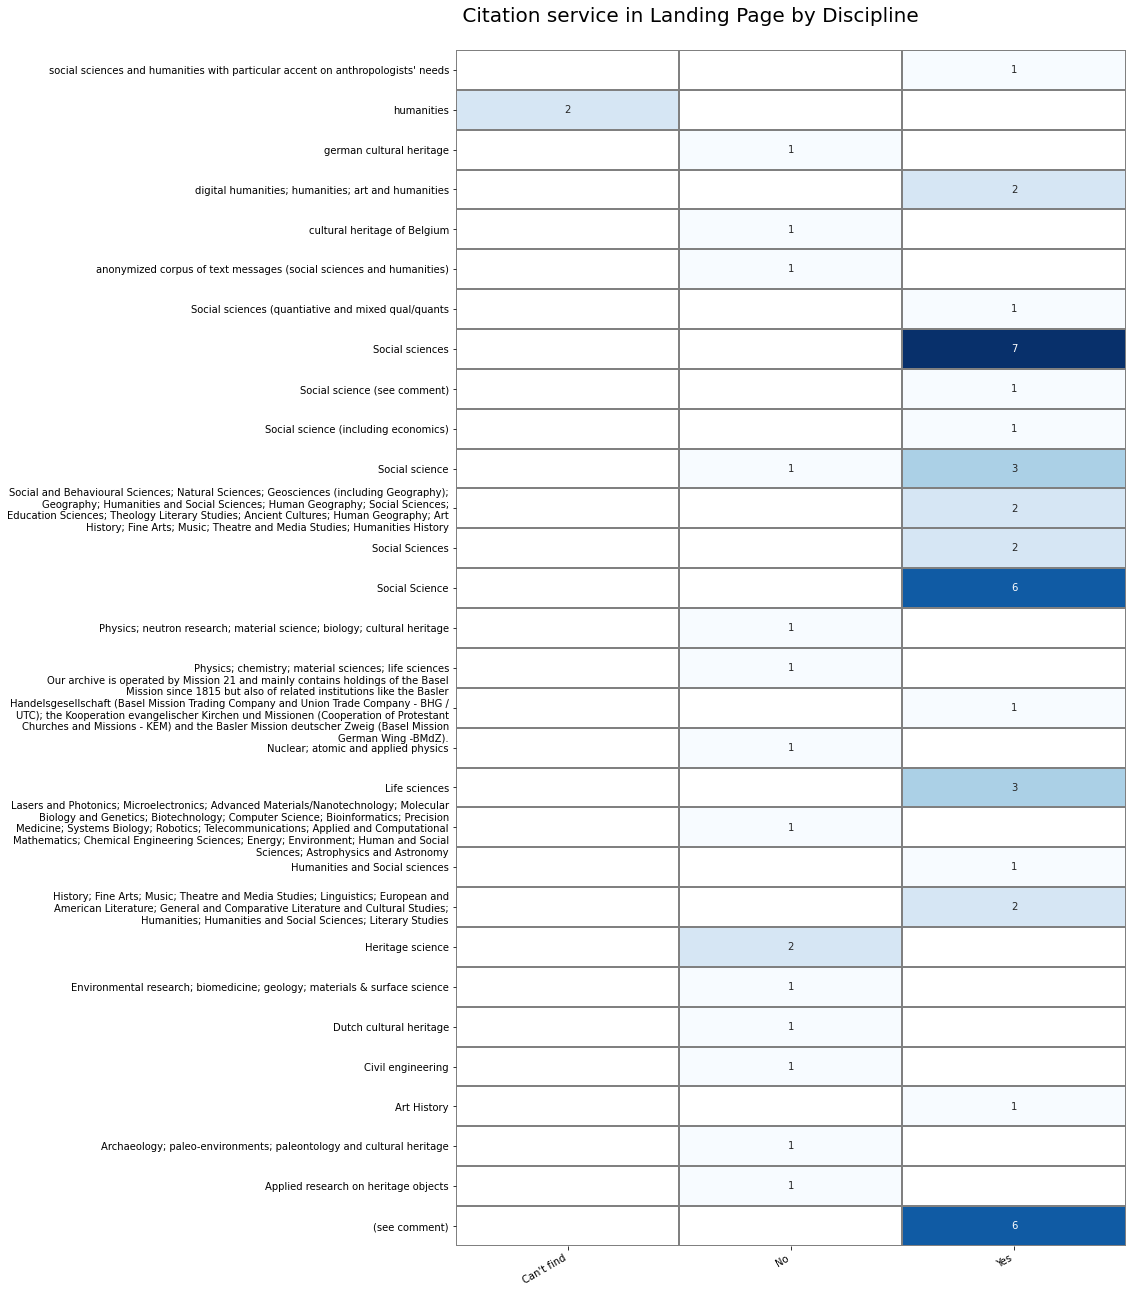

In [35]:
fig, ax = plt.subplots(figsize=(12, 22))
sns.heatmap(mc_a_df, annot=True, linewidths=0.1, fmt='.0f', ax=ax, cbar=None, cmap='Blues', linecolor='gray')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_yticklabels([textwrap.fill(e, 85) for e in mc_a_df.index], rotation=0)
ax.invert_yaxis()
ax.set_xlabel(None)
ax.set_ylabel(None)
#sns.heatmap(df, linewidths=2, linecolor='yellow')
title = ' Citation service in Landing Page by Discipline\n'
plt.title(title, loc='left', fontsize=20)
plt.show()

In [36]:
df_pis_kw["model_citation_lp"].fillna('na', inplace=True)

In [37]:
mcbc_a_df=df_pis_kw.groupby(['Community', 'model_citation_lp']).count()['Repository name'].unstack('model_citation_lp')

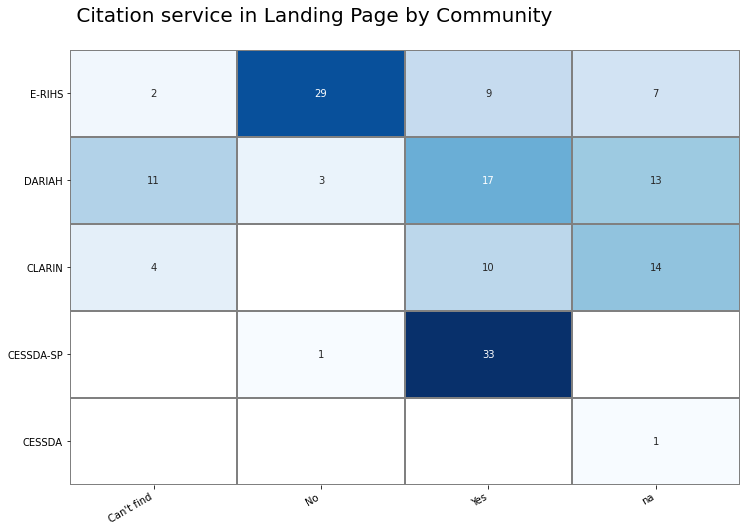

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(mcbc_a_df, annot=True, linewidths=0.1, fmt='.0f', ax=ax, cbar=None, cmap='Blues', linecolor='gray')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_yticklabels([textwrap.fill(e, 85) for e in mcbc_a_df.index], rotation=0)
ax.invert_yaxis()
ax.set_xlabel(None)
ax.set_ylabel(None)
#sns.heatmap(df, linewidths=2, linecolor='yellow')
title = ' Citation service in Landing Page by Community\n'
plt.title(title, loc='left', fontsize=20)
plt.show()

In [40]:
msn_a_df=df_pis_kw.groupby(['Community', 'metadataStandardName']).count()['Repository name'].unstack('metadataStandardName')
#tt_a_df.head(10)

Text(0.0, 1.0, ' Metadata Standard by Community\n')

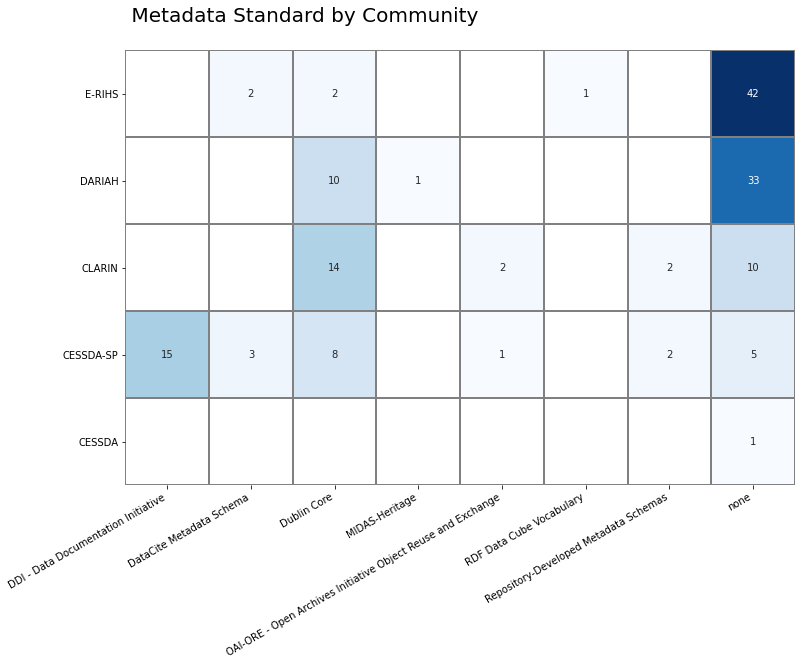

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(msn_a_df, annot=True, linewidths=0.1, fmt='.0f', ax=ax, cbar=None, cmap='Blues', linecolor='gray')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')
ax.set_yticklabels([textwrap.fill(e, 85) for e in mcbc_a_df.index], rotation=0)
ax.invert_yaxis()
ax.set_xlabel(None)
ax.set_ylabel(None)
#sns.heatmap(df, linewidths=2, linecolor='yellow')
title = ' Metadata Standard by Community\n'
plt.title(title, loc='left', fontsize=20)